Created by Gizem Dikdere.
396072 TU Berlin

# 1.Introduction

In 1990, Adobe released Adobe Photoshop and since then, it is understood that "camera never lies" is not sustainable anymore. It can be used easily by people for personal harmless purposes but also photo editing or changing can be for manipulating news about famous people or politicians.

Noawadays, not only photos but also videos can be used for manipulating people and changing truths in the eyes of people. "Deep Fakes" are throwing fear around[1].

In fact, the technology improved in in two opposite way. Some people are finding way to manipulate images or videos while some other people are finding ways to detect the changes in the images or videos. Adobe has started developing tools to detect the altered photos[2].

As a beginning, in this project, it is aimed to detect the altered/photoshoped photos for a given set of data by building CNN based tool.

# 2.Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import gc
np.random.seed(42)
print(os.listdir('/content/drive/My Drive/adams-faces-ss19/training/'))

['real', 'fake']


In [ ]:
train_dir_fake= 'drive/My Drive/adams-faces-ss19/training/fake'
train_fake= ['drive/My Drive/adams-faces-ss19/training/fake/{}'.format(i) for i in os.listdir(train_dir_fake)] 

train_dir_real= 'drive/My Drive/adams-faces-ss19/training/real'
train_real= ['drive/My Drive/adams-faces-ss19/training/real/{}'.format(i) for i in os.listdir(train_dir_real)] 

"train_fake" is a list that keeps the fake images' paths and names.
"train_real" is a list that keeps the real images' paths and names.

In [ ]:
train_imgs = train_fake + train_real

By adding train_fake and train_real, training images' paths and names are created. 

In [ ]:
del train_real
del train_fake
gc.collect()

8

Train_fake and train_real is deleted to save memory. Without getting rid of useless variables, the session on Google Colab is crashing earlier due to memory limits. 

In [ ]:
train_imgs

['drive/My Drive/adams-faces-ss19/training/fake/mid_139_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_40_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_257_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/easy_76_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_9_1110.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_272_1010.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_41_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_290_1100.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_316_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_170_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_291_1100.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_14_1101.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/easy_23_1100.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_195_1111.jpg',
 'drive/My Drive/adams-faces-ss19/training/fake/mid_275_1100.jpg',


"train_imgs" is a list that keeps the real and fake images' path and name. 

Let's plot the first 3 images. 

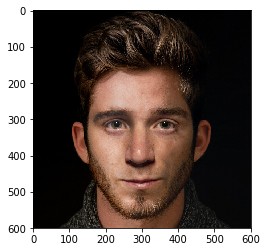

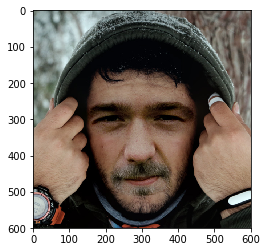

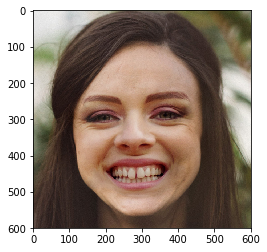

In [ ]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
def read_image(list_of_images):
    
    X = [] # X is for the images
    y = [] # y is for the labels 
    
    for image in list_of_images:
        X.append(cv2.imread(image, cv2.IMREAD_COLOR))
        if 'easy' in image:
            y.append(1)
        elif 'hard' in image:
            y.append(1)
        elif 'mid' in image:
            y.append(1)
        elif 'real' in image:
            y.append(0)
    
    return X, y

This function reads the images and turns them into arrays. X is keeping the image arrays and y is keeping the labels. If there is 'easy', 'hard' or 'mid' in the image name, it means that the image is fake and its label should be 1. If there is 'real' in the image name, it means that the image is real and its label should be 0. 

In [ ]:
X, y = read_image(train_imgs)

In [ ]:
del train_imgs
gc.collect()

0

Text(0.5, 1.0, 'Real vs Fake')

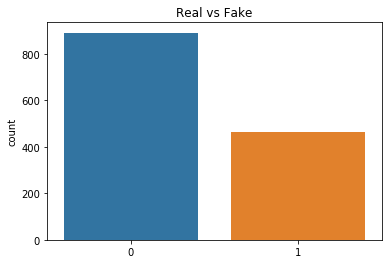

In [ ]:
import seaborn as sns

X = np.array(X)
y = np.array(y)

sns.countplot(y)
plt.title('Real vs Fake')


The graph above shows the count values for real and fake images. There are 891 real and 463 fake images in the training set. It seems like the data is not balanced. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (1083, 600, 600, 3)
Shape of validation images is: (271, 600, 600, 3)
Shape of labels is: (1083,)
Shape of labels is: (271,)


In [ ]:
del X
del y
gc.collect()

18

train_test_split is used to create the validation set. test_size is 0.2, which means that 20% of the training set will be randomly assigned as the validation set. 

There are 1083 train images and 271 validation images in total. The shape of the the images is 600,600,3. 3 at the end means that the photos are colored, not gray scaled. 

Now, the data is ready, the model can be built.

# 3.Models

###  3.1 CNN model

The first model is the simple convolutional neural network model. 

3 Conv2D layers, 3 MaxPooling layer, 1 Flatten, 1 Dense, 1 Dropout and 1 Dense layer with the sigmoid activation is used in total.

Sequential model is created and Conv2D layer is added. The first Conv2D layer has 32 neurons. Kernel size is (3,3) as filter. He_normal initializer, relu activation is used. Strides is (2,2) and input size is same with the shape of the images.  

After Conv2D layers , MaxPooling layers are used. The 2nd Conv2D layer after that is the same with the first except the number of neurons this time is 64.

After the last MaxPooling layer, Flatten is used.

There is one Dropout layer between the Dense layers to prevent overfitting. At the end, there is a Dense layer with 1 neuron and sigmoid activation since the problem is binary classification.

In [ ]:
import keras
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import Sequential

In [ ]:
seed=42

model = models.Sequential()
model.add(Conv2D(32, (3, 3), strides=(2,2), kernel_initializer=keras.initializers.he_normal(seed=seed) ,padding="same",activation='relu',input_shape=(600, 600, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), strides=(2,2), kernel_initializer=keras.initializers.he_normal(seed=seed) ,padding="same", activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)              0         
__________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc'])

The loss is binary_crossentropy, Adam optimizer with learning rate 1e-4 is chosen and as the metrics accuracy is used.

In the cells below, data augmentation is applied to training set. 

The size of the data set is small, that's why the augmentation is necessary to increase the size of the data set and prevent overfitting. No augmentation is applied to validation set, just rescaling to get values between 0 and 1.

In [ ]:
batch_size=16

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,   
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

Since the data imbalanced, class weights are used to cope with that.

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.76160338, 1.45564516])

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

history = model.fit_generator(train_generator,
                              steps_per_epoch= ntrain // batch_size,
                              epochs=100,
                              validation_data=val_generator,
                              class_weight=class_weights, 
                              validation_steps=nval // batch_size
                              ,callbacks=[ModelCheckpoint('learningrate100epoch1e-4.model', monitor='val_acc', save_best_only=True)]) 

Epoch 1/100
67/67 [==============================] - 85s 1s/step - loss: 0.6585 - acc: 0.6474 - val_loss: 0.6394 - val_acc: 0.6641
Epoch 2/100
67/67 [==============================] - 83s 1s/step - loss: 0.6505 - acc: 0.6522 - val_loss: 0.6605 - val_acc: 0.6706
Epoch 3/100
67/67 [==============================] - 83s 1s/step - loss: 0.6493 - acc: 0.6598 - val_loss: 0.6368 - val_acc: 0.6745
Epoch 4/100
67/67 [==============================] - 83s 1s/step - loss: 0.6526 - acc: 0.6508 - val_loss: 0.6666 - val_acc: 0.6275
Epoch 5/100
67/67 [==============================] - 81s 1s/step - loss: 0.6444 - acc: 0.6609 - val_loss: 0.6154 - val_acc: 0.7020
Epoch 6/100
67/67 [==============================] - 81s 1s/step - loss: 0.6528 - acc: 0.6494 - val_loss: 0.6424 - val_acc: 0.6667
Epoch 7/100
67/67 [==============================] - 81s 1s/step - loss: 0.6457 - acc: 0.6605 - val_loss: 0.6484 - val_acc: 0.6471
Epoch 8/100
67/67 [==============================] - 81s 1s/step - loss: 0.6485 - a

In [ ]:
model.load_weights('learningrate100epoch1e-4.model')

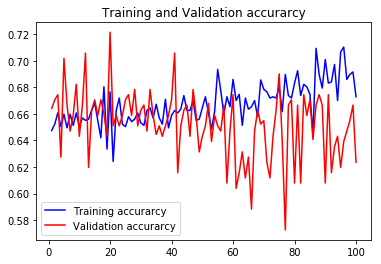

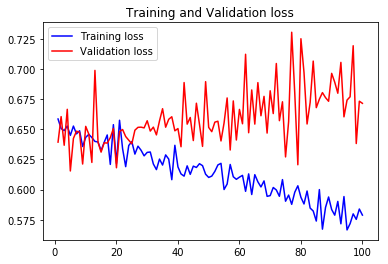

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

The model trained for 100 epochs. The first graph above shows the training accuracy and validation accuracy change between the epochs and the second one shows the training and validation loss. 

Although some techniques are used to overfitting, it can be seen that there is overfitting. Training accurcay is increasing while validation accuracy is decreasing. 

In the cells below, test images are read and rescaled with ImageDataGenerator. Then the predictions are created for the unknown test images.

In [ ]:
test_dir = 'drive/My Drive/adams-faces-ss19/testing/unknown'
test_imgs = ['drive/My Drive/adams-faces-ss19/testing/unknown/{}'.format(i) for i in os.listdir(test_dir)] #get test images

In [ ]:
X_test, y_test= read_image(test_imgs) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
testset= test_datagen.flow(x,shuffle= False, batch_size=1)

In [ ]:
probs=model.predict_generator(testset, steps= len(test_imgs))

In [ ]:
probs=probs.reshape((481,))
probs

array([0.40165296, 0.3060777 , 0.33087662, 0.28863636, 0.36211267,
       0.33003286, 0.37702435, 0.41556913, 0.39910737, 0.4339835 ,
       0.41045386, 0.3528285 , 0.40051904, 0.2870574 , 0.41071486,
       0.37007648, 0.31717283, 0.33947253, 0.37459773, 0.34447622,
       0.45395923, 0.31287903, 0.40622962, 0.39212874, 0.4427722 ,
       0.28969988, 0.28003225, 0.37354702, 0.2032317 , 0.3753341 ,
       0.22721301, 0.39891568, 0.4004346 , 0.37397847, 0.17289276,
       0.36220855, 0.39466345, 0.35641676, 0.40464962, 0.37434396,
       0.28923658, 0.4307086 , 0.29674911, 0.41554996, 0.40530252,
       0.3610758 , 0.3584099 , 0.36443365, 0.41848627, 0.46869567,
       0.34197497, 0.42658794, 0.35793605, 0.3726504 , 0.26466697,
       0.3275471 , 0.35995457, 0.4124109 , 0.40947276, 0.3700321 ,
       0.3623778 , 0.29518646, 0.41360918, 0.2993428 , 0.48172942,
       0.42433336, 0.43301836, 0.36035588, 0.39750078, 0.35082754,
       0.39724845, 0.32781518, 0.45412716, 0.30758852, 0.31316

In [ ]:
i=0
predictions = []
for i in probs: 
    if i > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
    i += 1
    if i %  len(x) == 0:
        break

Probabilites are turning into 1 if they are greater than 0.5, and into 0 if they are smaller than 0.5. 1 means that the predictions is 'fake', 0 means that the prediction is 'real'.

In [ ]:
sum(predictions)

0

All the probabilities is below 0.5 and the sum of the predictions is 0, which means that the model is unable to predict some images as 'fake'. 

Since the model is not performing well, a pretrained model is used for further improvement.

### 3.2 VGG&Transfer Learning

Instead of building models from scratch, one can start with some patterns that have been trained before. One can "transfer" learning to build accurate models at the same time save some time. Transfer learning can be done by the use of some pre-trained models that were trained for similar purposes before[3]. 

VGG16 is one of the models have been trained on the image net dataset[4]. VGG16 is used as the pre-trained model in this project.

In [ ]:
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator( 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                   zoom_range=0.2,
                                    horizontal_flip=True, preprocessing_function=preprocess_input)


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  

In [ ]:
batch_size=16
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

Until now, the training set and validation is created again with the ImageDataGenerator. Batch size is selected as 16.

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(600,600,3)) 
for layer in vgg.layers:
    layer.trainable=False

The layers that is coming from VGG16 is frozen, which means that they will not be trainable.

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.regularizers import l2

a=vgg.output
a=Flatten()(a)
a=Dense(16,activation='relu')(a)
a=Dense(16,activation='relu')(a) 
preds1=Dense(1,activation='sigmoid')(a) 

On top the layers coming from VGG, Flatten and Dense layers are added.Those layers are the layers that will be trainable.

In [ ]:
model1=Model(inputs=vgg.input,outputs=preds1)

In [ ]:
from keras import optimizers
model1.compile(optimizer=optimizers.Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy']) 

Adam optimizer with learning rate 1e-4 is chosen. Loss is again binary_crossentropy because the problem is binary classification problem. Lastlly, accuracy is chosen as the metrics.

In [ ]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600, 600, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0         
__________

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.75457571, 1.48202614])

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
step_size_train=train_generator.n // train_generator.batch_size
model1.load_weights('50epocheniyimodelibul.model')
history= model1.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train, 
                   epochs=25,
                   #class_weight= class_weights,
                   validation_data=val_generator,
                   validation_steps= len(val_generator)//val_generator.batch_size,
                    verbose=1
                             ,callbacks=[ModelCheckpoint('50epocheniyimodelibulustune25daha.model', monitor='val_acc', save_best_only=True)]) #model saveleri buraya alınabilir, sadece bu cell çalışır durumda kalacagı için)

Epoch 1/25
67/67 [==============================] - 107s 2s/step - loss: 0.5840 - acc: 0.7106 - val_loss: 0.8615 - val_acc: 0.4375
Epoch 2/25
67/67 [==============================] - 104s 2s/step - loss: 0.6162 - acc: 0.7031 - val_loss: 0.4943 - val_acc: 0.7500
Epoch 3/25
67/67 [==============================] - 104s 2s/step - loss: 0.5874 - acc: 0.7324 - val_loss: 0.4685 - val_acc: 0.8125
Epoch 4/25
67/67 [==============================] - 103s 2s/step - loss: 0.6053 - acc: 0.7186 - val_loss: 0.3850 - val_acc: 0.8125
Epoch 5/25
67/67 [==============================] - 104s 2s/step - loss: 0.5653 - acc: 0.7325 - val_loss: 0.8395 - val_acc: 0.6875
Epoch 6/25
67/67 [==============================] - 104s 2s/step - loss: 0.5896 - acc: 0.7250 - val_loss: 1.4846 - val_acc: 0.3125
Epoch 7/25
67/67 [==============================] - 104s 2s/step - loss: 0.5790 - acc: 0.7262 - val_loss: 0.7668 - val_acc: 0.6250
Epoch 8/25
67/67 [==============================] - 104s 2s/step - loss: 0.5696 - a

In [ ]:
model1.save_weights("mybestmodel.h5")

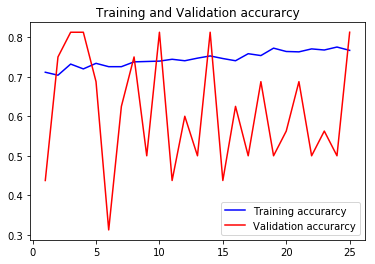

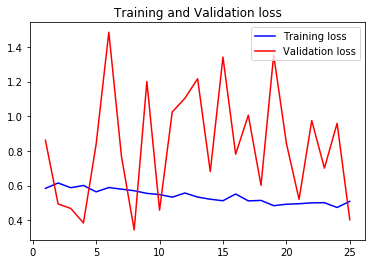

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

The model is trained for 50 epochs first. Then the weights are loaded and model is trained for another 25 epochs. The first graph above shows training and validation accuracy change between the epochs, while the second one shows the training and validation loss. The training accuracy is increasing gradually, while the validation accuracy is fluctuating. Between the epochs, only the best model in terms of validation accuracy is chosen and predictions are made according to that model.

In [ ]:
model1.load_weights('50epocheniyimodelibul.model')

In [ ]:
from keras.applications.vgg16 import preprocess_input

In the cells below, test images are read and rescaled with ImageDataGenerator. Then the predictions are created for the unknown test images.

In [ ]:
test_dir = 'drive/My Drive/adams-faces-ss19/testing/unknown'
test_imgs = ['drive/My Drive/adams-faces-ss19/testing/unknown/{}'.format(i) for i in os.listdir(test_dir)] #get test images
X_test, y_test= read_image(test_imgs) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
testset= test_datagen.flow(x,shuffle= False, batch_size=1)

In [ ]:
probsVGG=model1.predict_generator(testset, steps= len(testset), workers=0)
probsVGG

array([[4.89526480e-01],
       [1.20447561e-01],
       [6.62890315e-01],
       [6.01404533e-03],
       [1.63655095e-02],
       [4.82408970e-04],
       [3.23242486e-01],
       [5.61461411e-02],
       [3.58763725e-01],
       [4.42245126e-01],
       [3.66770138e-04],
       [3.20801437e-01],
       [3.77007067e-01],
       [1.10427998e-02],
       [2.59313613e-01],
       [2.98985466e-02],
       [7.98167810e-02],
       [6.28597587e-02],
       [5.96651793e-01],
       [5.15507102e-01],
       [2.94388950e-01],
       [1.42774537e-01],
       [4.40820515e-01],
       [1.63863987e-01],
       [7.17652962e-02],
       [9.60684270e-02],
       [1.21176489e-01],
       [7.36114025e-01],
       [7.63733506e-01],
       [9.81334925e-01],
       [1.25530973e-01],
       [7.43790507e-01],
       [2.52115041e-01],
       [9.02333856e-02],
       [6.65798664e-01],
       [6.87301397e-01],
       [1.80412263e-01],
       [1.88310057e-01],
       [6.76222071e-02],
       [1.32934615e-01],


In [ ]:
probsVGG[probsVGG>=0.5] = 1
probsVGG[probsVGG<0.5] = 0
print(sum(probsVGG))

176.0


The probabilities are calculated with predict generator. The probability is greater than 0.5 means that the prediction is yielding 'fake'. The probsVGG is summed and the result is 176, which means that the model found 176 fake images in the unknown test set. 

In the cells below, the appropriate dataframe is created with one column for the names of the images and one column for the predictions.

In [ ]:
type(probsVGG)
probsVGG.shape
probsVGG=probsVGG.reshape(481,). astype('int')  

In [ ]:
test_imgs1= np.array(test_imgs)
test_imgs2= pd.DataFrame(test_imgs1)
s=test_imgs2.iloc[:, 0]
s2=s.str.split('/', expand=True)
s3= s2.iloc[:, 5]
s4= s3.str.split('.', expand=True)
names= s4.iloc[: , 0:1]

In [ ]:
names = np.array(names)

In [ ]:
names=list(names)

In [ ]:
df_solution = pd.DataFrame({"ID": names, "fake": probsVGG })

df_solution['ID'] = df_solution['ID'].map(lambda x: str(x).lstrip('[').rstrip(']'))




In [ ]:
import string
df_solution['ID'] = df_solution['ID'].apply(lambda x:''.join([i for i in x 
                                                  if i not in string.punctuation]))
df_solution.to_csv("sonmodelinteger.csv", index = False)

In [ ]:
df_solution.head()

,ID,fake
0,3aa9db1fcbef67e08785,0
1,0e235e504ac49fe5aa23,0
2,bc0fce481ee9997e04a5,1
3,42f817bfa06978b3bc54,0
4,c9e66c4a811a3767cc4f,0


#### Predictions for validation set and calculating confusion matrix and accuracy

Below, the predictions are calculated for the validation set with the VGG&Transfer laerning model.

In [ ]:
model1.load_weights('50epocheniyimodelibulustune25daha.model')

In [ ]:
pred_val=model1.predict(X_val)
pred_val

array([[1.30511522e-02],
       [6.92729115e-01],
       [5.47739863e-03],
       [1.37114108e-01],
       [1.90158278e-01],
       [4.32519138e-01],
       [6.73544705e-02],
       [3.51756155e-01],
       [8.96176279e-01],
       [4.11954820e-02],
       [2.21660435e-02],
       [1.32380426e-02],
       [4.23808098e-02],
       [8.63155127e-01],
       [2.92661667e-01],
       [1.44780159e-01],
       [3.23901206e-01],
       [6.92787170e-01],
       [9.03365135e-01],
       [1.49287194e-01],
       [1.22087330e-01],
       [6.53390288e-01],
       [2.76059687e-01],
       [9.87283349e-01],
       [5.80510259e-01],
       [5.02614796e-01],
       [6.37812614e-01],
       [2.87725449e-01],
       [4.59216624e-01],
       [8.38966012e-01],
       [2.33262777e-04],
       [7.53448606e-01],
       [5.39926052e-01],
       [5.61884761e-01],
       [1.42897695e-01],
       [1.82490140e-01],
       [5.61156571e-02],
       [9.27545190e-01],
       [4.37239885e-01],
       [9.56189632e-01],


In [ ]:
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(y_val, pred_val)

array([[114,  66],
       [ 35,  56]])

In [ ]:
print("Accuracy:", accuracy_score(y_val, pred_val))

Accuracy: 0.6273062730627307


The confusion matrix and the accuracy is calculated according to validation set. According to confusion matrix, 114 real images are found by the model and those 114 images are really real. 56 fake images are found by the model and those 56 fake images are really fake. 
The validation accuracy is around 0.63.

The second model is chosen because it is performing better than the first simple CNN model.

### 3.3 Benchmark

As a benchmark model, DecisionTreeClassifier is used.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
ntrain = X_train.shape[0]
ntest = X_val.shape[0]
print(X_train.shape)

(907, 600, 600, 3)


In [ ]:
X_train = X_train.reshape(ntrain,X_train.shape[1]*X_train.shape[2]*3)
X_val = X_val.reshape(ntest,X_val.shape[1]*X_val.shape[2]*3)
print(X_train.shape)
print(X_val.shape)

(907, 1080000)
(447, 1080000)


In [ ]:
y_train=y_train.reshape(ntrain,1)
y_val=y_val.reshape(ntest,1)

In [ ]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)

In [ ]:
y_pred = tree.predict(X_val)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.5749440715883669


Prediction is made on validation set. The accuracy is 0.57 with the benchmark model. 

The second model with VGG and transfer learning is performing better than the benchmark model.

# 4.Discussion

Firstly, fine tuning is made by hand. Secondly, there is no solution found to the fluctuations in validation accuracies. The reason for this behavior may be the small size of validation set. For further improvement, some regularization techniques may be tried.

# 5.Conclusion

In conlusion, 3 models are built in this project. A CNN model, CNN-based pretrained model and a benchmark model. The comparison is made according to their accuracies. VGG&Transfer learning model is selected as the best performing one. The predictions is submitted via Kaggle page. The auc score acquired from Kaggle is 0.60028. 

# 6.References

[1]Deep Fakes: Let's Not Go Off The Deep End, Jeffrey Westling, Wed, Jan 30th 2019 12:05pm. https://www.techdirt.com/articles/20190128/13215341478/deep-fakes-lets-not-go-off-deep-end.shtml

[2]Adobe Shows Off First Research for Tools to Detect Manipulated Photos,Andrew Liszewski, 6/14/19 11:35am. https://gizmodo.com/adobe-shows-off-first-research-for-tools-to-detect-mani-1835516127

[3]Transfer learning from pre-trained models, Pedro Marcelino, Oct 23, 2018. https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

[4]Deep Learning For Beginners Using Transfer Learning In Keras, Aditya Ananthram, Oct 17, 2018. https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e


